# Predator-Prey Dynamics Model

## Introduction
The following tutorial aims to describe a more dynamic model using the ABSESpy API. It consists of an implementation of the Lotka-Volterra model which presents a simple ecosystem with two species: predators and preys. This model was originally proposed as a system of first-order, non-linear differential equations and has found its computation, individual-based simulation counterparts.

This introductory tutorial illustrates how the ABSESpy API handles the creation of new agents as well as the death or annihilation of agents. The model is a good first example to show the interlinkages and micro-interactions between agents using the API.

The model aims to capture the dynamical evolution of the population of wolves and the population of sheep. It recreates a simple food chain where wolves feed on sheep and, in turn, sheep feed on grass. Both sheep and wolves have energy levels that are invariable affected by their movement. A move costs energy that can only be replenish by eating. 

## The Grass Patchcell

As is it usual with a heuristic model, we want to place our agents in an virtual environment. ABSESpy offers the posibility to create a grid by means of the `create_module` method of the `BaseNature` class. It is often not necessary to import this class, nor other classes that support it, as the main class, `MainModel`, will create an instance of it at the moment of its creation. However, here we will import the `PatchCell` class to creating a subclass that will suit the needs of the model. Namely, we want our patch cells to contain grass for the sheep to eat.

We will pass this new class to the `create_module` method as a parameter. That will make it the default patch cell for the model.

The class `Grass` will be fundamentally the same as its parent class, `PatchCell`, except for the added property *empty* that will be used to determine whether there is grass on the cell currently or not. We will also need to method to regrow the grass after it has been consumed. 

In [1]:
import numpy as np

from abses import Actor, MainModel, PatchCell
from abses.datacollection import DataCollector

# Instantiate random number generator
rng = np.random.default_rng(42)

In [2]:
class Grass(PatchCell):
    """Custom patch cell class"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.empty = False
        self._countdown = 5

    def grow(self):
        """Grow some grass on the cell every 5 ticks."""
        # countdown on brown patches: if you reach 0, grow some grass
        if self.empty == True:
            if self._countdown <= 0:
                self.empty = False
                self._countdown = 5
            else:
                self._countdown -= 1

## Agents Classes

We need at least two custom classes. One to represent wolves and another to represent sheep. Across these two classes there is common functionality that can be abstracted into a parent class. In particular, we may want to define a shared method for movement, reproduction and energy consumption. From there, a class `Wolf` can be define to handle how the wolves will feed on sheep and a class `Sheep` to handle how the sheep will feed on grass.

The parent class `Animal` will have the following properties:

- *energy*: the amount of energy the animal has. It will be used to determine whether the animal can move or reproduce.
- *rep_rate*: the rate at which the animal reproduces. It will be used to determine whether the animal can reproduce.

There will be methods defined for this class to handle agents' movement, reproduction and death.

In [3]:
class Animal(Actor):
    def __init__(self, model, rep_rate, *args, **kwargs):
        Actor.__init__(self, model, *args, **kwargs)
        self.energy = 5
        self.rep_rate = rep_rate

    def step(self):
        pass

    def update(self):
        # consume energy
        self.energy -= 1

        if self.energy <= 0:
            self.die()

    def move(self):
        neighborhood = self.layer.get_neighborhood(
            self.pos, moore=True, include_center=False
        )

        # pick new position randomly
        new_pos = rng.choice(neighborhood)
        self.move_to(new_pos)

    def reproduce(self):
        if rng.uniform(0, 1) < self.rep_rate:
            self.energy /= 2
            offspring = self.__class__(
                model=self.model, rep_rate=self.rep_rate
            )
            self.model.agents.add(offspring)
            offspring.put_on_layer(self.layer, self.pos)

At each step, both sheep and wolves will move randomly to a new neighboring cell. Then, they will eat if there is food avaiable to them. Given a certain probability, they will reproduce. That probability is determined by the *rep_rate* property. Finally, they will be lose some energy.

In [4]:
class Wolf(Animal):
    def step(self):
        self.move()
        self.eat_sheep()
        self.reproduce()
        self.update()

    def eat_sheep(self):
        """If there is a sheep in the cell, eat it and gain 2 energy."""
        sheep = self.here.select("Sheep")
        if a_sheep := sheep.random.choice(when_empty="return None"):
            a_sheep.die()
            self.energy += 2


class Sheep(Animal):
    def step(self):
        self.move()
        self.eat_grass()
        self.reproduce()
        self.update()

    def eat_grass(self):
        """If there is a grass in the cell, eat it and gain 2 energy."""
        if self.loc("empty") is False:
            self.energy += 2
            self.alter_nature("empty", True)

## The Model
Our model consists of two components. One initialization method and a step method. Most of the complexity of the model lies in interaction between agents and the added feature of the grass patch cells. 

The WolfSheepModel class is a subclass of MainModel and represents a simulation model for a predator-prey system involving wolves and sheep. In the constructor (__init__), the model initializes a grid with cells represented by the Grass class. It then creates a list of all cells in the grid. The model creates a specified number of Wolf and Sheep agents with given reproduction rates. These agents are then placed randomly on the grid. A DataCollector instance is also initialized to track the populations of wolves and sheep in the model.

The step method represents a single time step in the simulation. In each time step, the step method of all Sheep and Wolf agents is triggered, allowing them to perform their actions. Then, the grow_grass method is called for each cell in the grid, simulating the growth of grass. The model checks if the populations of sheep and wolves are empty or if the population of sheep has reached 400, in which case it stops the simulation by setting self.running to False. Finally, the collect method of the DataCollector is called to collect data for the current time step.

In [5]:
class WolfSheepModel(MainModel):
    def __init__(
        self, n_sheep, n_wolves, w_rep_rate, s_rep_rate, shape, *args, **kwargs
    ):
        super().__init__(*args, **kwargs)

        # initialize a grid
        self.nature.create_module(
            how="from_resolution",
            shape=shape,
            cell_cls=Grass,
        )

        self._cells = [
            cell for row in self.nature.major_layer.cells for cell in row
        ]

        # add sheep and wolves
        self.agents.create(Wolf, n_wolves, rep_rate=w_rep_rate)
        self.agents.create(Sheep, n_sheep, rep_rate=s_rep_rate)

        # place both sheep and wolves randomly on the grid, grass dispersed evenly
        for actor in self.actors:
            actor.put_on_layer(
                layer=self.nature.major_layer,
                pos=(rng.integers(0, shape[0]), rng.integers(0, shape[1])),
            )

        self.datacollector = DataCollector(
            model=self,
            model_reporters={
                "pop_wolves": lambda m: len(m.actors.select("Wolf")),
                "pop_sheep": lambda m: len(m.actors.select("Sheep")),
            },
        )

    def step(self):
        self.actors.select("Sheep").trigger("step")
        self.actors.select("Wolf").trigger("step")

        # grow grass
        for cell in self._cells:
            cell.grow_grass()

        # end model
        if (
            self.actors.select("Sheep") == []
            and self.actors.select("Wolf") == []
        ):
            self.running = False
        elif len(self.actors.select("Sheep")) >= 400:
            self.running = False

        # collect data
        self.datacollector.collect()

## Simulations and Discussion
We are now able to run simulations. We instantiate a model to run for 100 steps. It will have a ratio of 4 sheep for every wolf. We keep the reproduction rates low. We will then plot the resulting evolution in the populations of wolves and sheep. 

In [6]:
parameters = {
    "time": {
        "end": 100,
    }
}

model = WolfSheepModel(
    n_sheep=80,
    n_wolves=20,
    w_rep_rate=0.2,
    s_rep_rate=0.1,
    shape=(12, 12),
    parameters=parameters,
)
model.run_model()

[2024-02-29 14:48:19][human          ] | Initializing a new Human Module...
[2024-02-29 14:48:19][nature         ] | Initializing a new Base Nature module...
[2024-02-29 14:48:19][nature         ] | Initializing a new Model Layer...
[2024-02-29 14:48:19][nature         ] | Using rioxarray version: 0.13.4
[2024-02-29 14:48:19][container      ] | Created 20 actors of breed Wolf
[2024-02-29 14:48:19][container      ] | Created 80 actors of breed Sheep
[2024-02-29 14:48:19][datacollection ] | DataCollector component initialized.
[2024-02-29 14:48:19][main           ] | Setting up WolfSheepModel...
[2024-02-29 14:48:19][main           ] | Ending WolfSheepModel


In this single run, the results show diverging populations. At first, the sheep population declines and the wolf population increases. Then, the wolf population declines and the sheep population increases. All wolves disappear and the sheep population reaches the carrying capacity of the environment.

<Axes: >

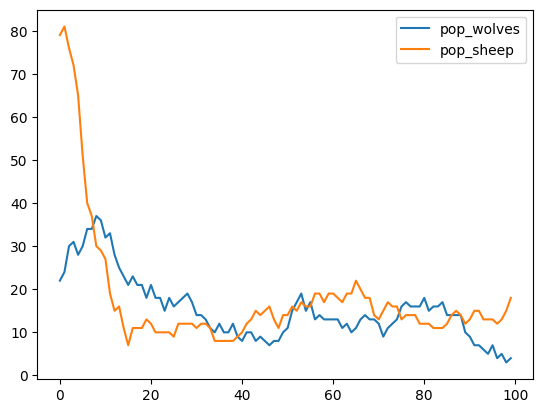

In [7]:
model.datacollector.get_model_vars_dataframe().plot()